In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm 
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
import pickle
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/large-fakenews-dataset/clean_large_full_dataset.csv


In [2]:
data = pd.read_csv('/kaggle/input/large-fakenews-dataset/clean_large_full_dataset.csv')
data.shape

(32392, 16)

In [3]:
data=data.reset_index(drop=True)
data.head()

,Unnamed: 0,title,content,date,Publisher,link,Label,clean_content,content_lower,content_tokenied,content_contradict,content_nodigit,lemmatized,day,month,year
0,0,government must provide security for aml in th...,"Last week, armed men carrying machetes deadly ...",2023-07-31,Gnn News Liberia,https://gnnliberia.com/government-must-provide...,1.0,Last week armed men carrying machetes and othe...,last week armed men carrying machetes deadly w...,['last week armed men carrying machetes and ot...,last week armed men carrying machetes deadly w...,last week armed men carrying machetes deadly w...,week armed man carry machete deadly weapon att...,31,7,2023
1,1,liberia army chief of staff predicts unforesee...,"Amid recent coup Niger, Chief Staff Liberian a...",2023-07-28,Gnn News Liberia,https://gnnliberia.com/liberia-army-chief-of-s...,1.0,Amid recent coup in Niger the Chief Staff of t...,amid recent coup niger chief staff liberian ar...,['amid recent coup in niger the chief staff of...,amid recent coup niger chief staff liberian ar...,amid recent coup niger chief staff liberian ar...,amid recent coup niger chief staff liberian ar...,28,7,2023
2,2,guns machetes men attack vandalize arcelormit...,"A group unknown men said Zolowee, town proximi...",2023-07-30,Gnn News Liberia,https://gnnliberia.com/guns-machetes-men-attac...,1.0,A group of unknown men said to be from Zolowee...,group unknown men said zolowee town proximity ...,['a group of unknown men said to be from zolow...,group unknown men said zolowee town proximity ...,group unknown men said zolowee town proximity ...,group unknown man say zolowee town proximity a...,30,7,2023
3,3,president weah commits to delivering violent ...,"Liberian President, George Weah, pledged deliv...",2023-07-27,Gnn News Liberia,https://gnnliberia.com/president-weah-commits-...,1.0,Liberian President George Weah has pledged to ...,liberian president george weah pledged deliver...,['liberian president george weah has pledged t...,liberian president george weah pledged deliver...,liberian president george weah pledged deliver...,liberian president george weah pledge deliver ...,27,7,2023
4,4,new world bank liberia country manager arrives,"MONROVIA, July 31, 2023 â€“ The new World Bank...",2023-07-31,Gnn News Liberia,https://gnnliberia.com/new-world-bank-liberia-...,1.0,MONROVIA July 31 2023 â€“ The new World Bank C...,monrovia july 31 2023 â€“ new world bank count...,['monrovia july 31 2023 â€“ the new world bank...,monrovia july 31 2023 â€“ new world bank count...,monrovia july â€“ new world bank country man...,"monrovia july â€ "" new world bank country m...",31,7,2023


In [4]:
data['Label'] = data['Label'].round().astype(int)
data.rename(columns={'Label': 'label'}, inplace=True)

In [5]:
data['text'] = data['title'].astype(str) + " " + data['clean_content'].astype(str)

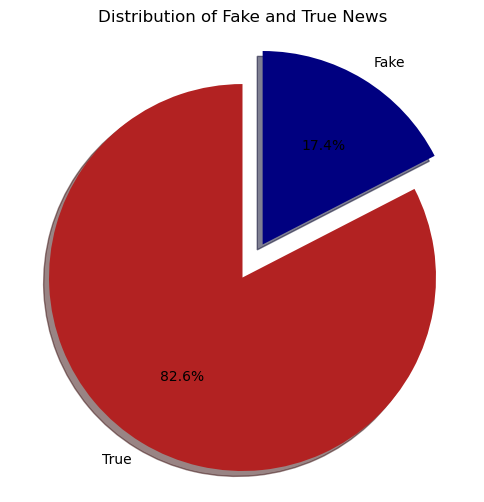

In [6]:
# Count the occurrences of each label
label_counts = data['label'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['True','Fake'],autopct='%1.1f%%')
plt.title("Distribution of Fake and True News")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

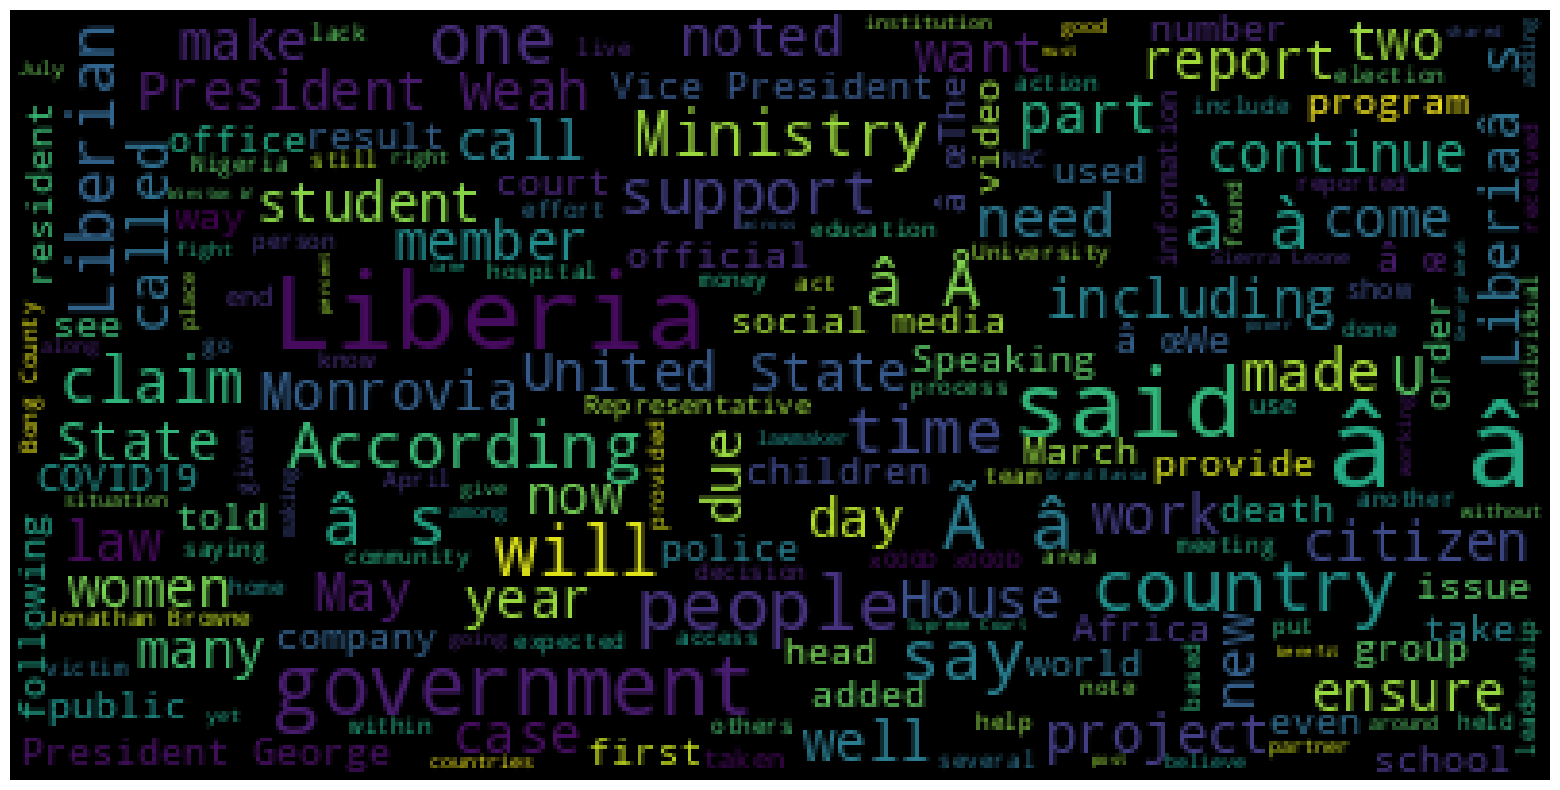

In [7]:
# Generate a basic word cloud 
from wordcloud import WordCloud, ImageColorGenerator

text = " ".join([x for x in data['text']])
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=30, max_words=1000).generate(text)

# Display the generated image:
plt.figure(figsize= [20,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [8]:
# Split the dataset
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42,stratify = data['label'])

print(X_train.shape)
print(X_test.shape)

(25913,)
(6479,)


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

print(tfidf_train.shape)
print(tfidf_test.shape)

(25913, 217623)
(6479, 217623)


In [ ]:
# Calculate class weights
total_samples = len(y_train)
class_0_samples = np.sum(y_train == 0)
class_1_samples = np.sum(y_train == 1)

weight_0 = total_samples / (2 * class_0_samples)  # You might need to adjust this value
weight_1 = total_samples / (2 * class_1_samples)  # You might need to adjust this value

class_weights = {0: weight_0, 1: weight_1}
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 6, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_lambda': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    LGBMClassifier(random_state=42, class_weight=class_weights),
    param_grid,
    scoring='f1_macro',  # You can adjust the scoring metric
    cv=3
)
grid_search.fit(tfidf_train, y_train)

# Get the best model from the grid search
best_lgbm_classifier = grid_search.best_estimator_

# Train the best model on the entire training set
best_lgbm_classifier.fit(tfidf_train, y_train)

# Evaluate the best model on the test set
predicted_labels_test = best_lgbm_classifier.predict(tfidf_test)

accuracy_test = best_lgbm_classifier.score(tfidf_test, y_test)
precision_test = precision_score(y_test, predicted_labels_test)
recall_test = recall_score(y_test, predicted_labels_test)
f1_test = f1_score(y_test, predicted_labels_test)

print(f"Final Model Accuracy on test set: {accuracy_test:.2f}")
print(f"Final Model Precision on test set: {precision_test:.2f}")
print(f"Final Model Recall on test set: {recall_test:.2f}")
print(f"Final Model F1-Score on test set: {f1_test:.2f}")
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels_test))
print("Report : \n {}".format(classification_report(y_test, predicted_labels_test)))
disp.plot()
plt.show()

In [ ]:
# Save the trained model to a file
model_filename = "Best_LGBMClassifier_Final_model_X1.pkl"
with open(model_filename, 'wb') as model_file:
    pickle.dump(best_lgbm_classifier, model_file)

print(f"Model saved to {model_filename}")

In [10]:
# Save the TF-IDF vectorizer
tfidf_filename = 'Best_tfidf_vectorizer_Final_model_X1.pkl'
with open(tfidf_filename, 'wb') as tfidf_file:
    pickle.dump(tfidf_vectorizer, tfidf_file)
print(f"Vectorizer saved to {tfidf_filename}")

Vectorizer saved to Best_Model_tfidf_vectorizer23131.pkl
